In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/10/21 01:54:53 WARN Utils: Your hostname, DESKTOP-AEUBGUH resolves to a loopback address: 127.0.1.1; using 172.17.252.233 instead (on interface eth0)
24/10/21 01:54:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/21 01:54:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
pd_df = pd.read_parquet("../data/clean_data/df_trans_sent_comments.parquet")
df = spark.createDataFrame(pd_df)
df = df.repartition(100)
df.cache()

DataFrame[comment_id: string, author: string, author_channel_id: string, text: string, like_count: double, published_at: timestamp, updated_at: timestamp, totalReplyCount: double, video_id: string, translation: string, clean_text: string, sentiment: double]

# Sentiment Analysis using RoBERTa
NLP Transformer-based Models used for Sentiment Analysis

RoBERTa: Robustly Optimized BERT Approach
BERT: Bidirectional Encoder Representations from Transformers

In [4]:
from transformers import pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# RoBERTa (Robustly Optimized BERT Approach)
sentiment_model = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

# Create a python function to get the sentiment
def get_sentiment(text):
    try:
        sentiment = sentiment_model(text)
        return sentiment[0]
    except Exception as e:
        return str(e)

# Create an User-Defined Function to apply a Python function into PySpark framework to be executed in parallel
sentiment_udf = udf(get_sentiment, ArrayType(StringType()))

# Apply the function
df_with_sentiment = df.withColumn("emotions", sentiment_udf(df['translation']))

/home/ivanseldasp/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [5]:
from pyspark.sql.functions import udf, col, slice
from pyspark.sql.types import FloatType

# Diccionario que mapea emociones a un valor entre -1 y 1
emotion_sentiment_map = {
    'admiration': 1,
    'approval': 0.8,
    'gratitude': 1,
    'neutral': 0,
    'optimism': 0.7,
    'disapproval': -0.7,
    'realization': 0.5,
    'curiosity': 0.4,
    'excitement': 0.9,
    'annoyance': -0.6,
    'joy': 1,
    'disappointment': -0.6,
    'confusion': -0.3,
    'surprise': 0.2,
    'love': 1,
    'pride': 0.9,
    'sadness': -0.8,
    'caring': 0.8,
    'amusement': 0.7,
    'anger': -0.9,
    'desire': 0.5,
    'disgust': -1,
    'relief': 0.6,
    'fear': -0.9,
    'remorse': -0.7,
    'grief': -0.9,
    'embarrassment': -0.4,
    'nervousness': -0.5
}

# Check whether the input is empty
def calculate_sentiment(emotions):
    if len(emotions) == 0:
        return 0  
    
    # Create an initial list with all the emotion's scores
    initial_score_list = []
    for n in range(len(emotions)):
        score = emotions[n]['score']
        initial_score_list.append(score)
    
    # Sum the total initial score
    initial_score_total = sum(initial_score_list)
    
    # Multiply each percentage of the emotion per the value from the emotion_dictionary_values
    emotion_score_list = []
    for n in range(len(emotions)):
        label = emotions[n]['label']
        score = initial_score_list[n] / initial_score_total
        final_score = emotion_sentiment_map[label] * score
        emotion_score_list.append(final_score)
    
    # Sum the total value pondered
    return sum(emotion_score_list)

In [6]:
# Create an User-Define Function to run the Python code into Spark
sentiment_udf = udf(calculate_sentiment, FloatType())

# Apply the function to the Spark dataframe
df_final = df_with_sentiment.withColumn("sentiment_score", sentiment_udf(col("emotions")))

In [7]:
df_final = df_final.select("video_id", "like_count", "sentiment_score")

24/10/21 01:55:22 WARN TaskSetManager: Stage 0 contains a task of very large size (6407 KiB). The maximum recommended task size is 1000 KiB.
ERROR:root:Exception while sending command.                      (0 + 12) / 100]
Traceback (most recent call last):
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 60370)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in

Py4JError: An error occurred while calling o94.parquet

# SQL Query

In [8]:
# Register the DataFrame as a temporary SQL view
df_final.createOrReplaceTempView("sentiment_data")

In [9]:
# Execute SQL query to apply the same logic as the PySpark code
df_weighted_sentiment_sum = spark.sql("""
    SELECT 
        video_id,
        (SUM((1 + like_count) * sentiment_score) / SUM(1 + like_count)) AS weighted_score
    FROM 
        sentiment_data
    GROUP BY 
        video_id;
""")

In [10]:
df_weighted_sentiment_sum.count()

24/10/21 01:29:33 WARN TaskSetManager: Stage 0 contains a task of very large size (6407 KiB). The maximum recommended task size is 1000 KiB.


1767

In [11]:
df_weighted_sentiment_sum.write.parquet("../data_df_weighted.parquet")

ERROR:root:Exception while sending command.                      (0 + 12) / 100]
Traceback (most recent call last):
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49046)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/home/ivanseldasp/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in

Py4JError: An error occurred while calling o96.showString

# Plotting test

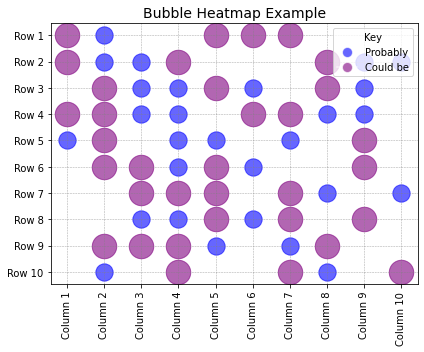

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data for a bubble heatmap
data = np.random.choice([0, 1, 2], size=(10, 10))  # Random data with values 0, 1, 2
df = pd.DataFrame(data, columns=[f"Column {i+1}" for i in range(10)], 
                  index=[f"Row {i+1}" for i in range(10)])

# Create the bubble heatmap
plt.figure(figsize=(6, 5))

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        value = df.iloc[i, j]
        if value != 0:
            plt.scatter(j, i, s=value * 300, color='blue' if value == 1 else 'purple', alpha=0.6)

# Customizing the heatmap
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=90)
plt.yticks(np.arange(df.shape[0]), df.index)
plt.gca().invert_yaxis()  # To match the orientation

plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Creating a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Probably', markersize=10, 
                               markerfacecolor='blue', alpha=0.6),
                   plt.Line2D([0], [0], marker='o', color='w', label='Could be', markersize=10, 
                               markerfacecolor='purple', alpha=0.6)]

plt.legend(handles=legend_elements, title='Key', loc='upper right')

plt.title('Bubble Heatmap Example', fontsize=14)
plt.tight_layout()
plt.show()

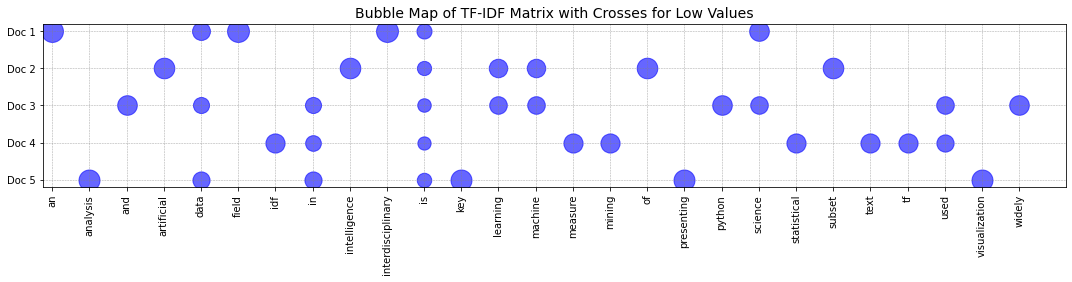

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Sample text data
documents = [
    "Data science is an interdisciplinary field.",
    "Machine learning is a subset of artificial intelligence.",
    "Python is widely used in data science and machine learning.",
    "TF-IDF is a statistical measure used in text mining.",
    "Visualization is key in presenting data analysis."
]

# Generate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Define a threshold for low values
low_value_threshold = 0.1

# Creating a bubble map
plt.figure(figsize=(15, 10))

# Iterate over the DataFrame to create the bubble map with crosses for low values
for row_idx in range(tfidf_df.shape[0]):
    for col_idx in range(tfidf_df.shape[1]):
        value = tfidf_df.iloc[row_idx, col_idx]
        if value > 0:
            # Plot bubbles for non-zero values
            plt.scatter(col_idx, row_idx, s=value * 1000, alpha=0.6, color='blue')
            # Plot a cross for low TF-IDF values
            if value < low_value_threshold:
                plt.scatter(col_idx, row_idx, s=100, marker='x', color='red', alpha=0.8, linewidths=2)

# Customizing the bubble map
plt.xticks(np.arange(tfidf_df.shape[1]), tfidf_df.columns, rotation=90)
plt.yticks(np.arange(tfidf_df.shape[0]), [f"Doc {i+1}" for i in range(tfidf_df.shape[0])])
plt.gca().invert_yaxis()  # To match the heatmap orientation
plt.gca().set_aspect('equal', adjustable='box')


plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Title and layout adjustments
plt.title('Bubble Map of TF-IDF Matrix with Crosses for Low Values', fontsize=14)
plt.tight_layout()
plt.show();

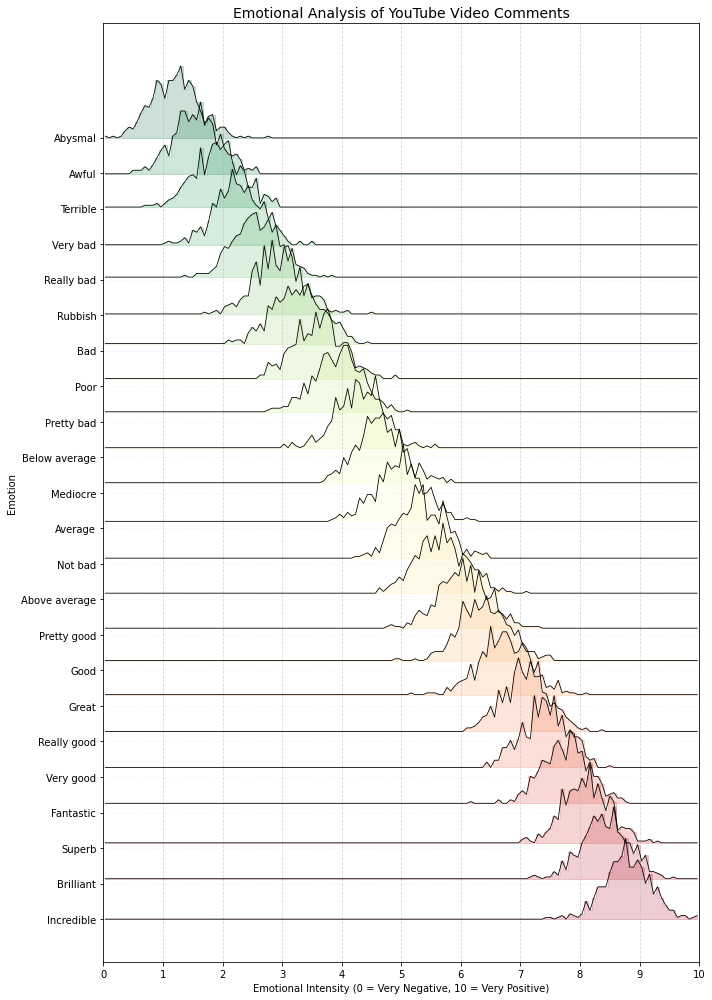

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Crear los datos de ejemplo similares al gráfico que compartiste
emotions = [
    "Abysmal", "Awful", "Terrible", "Very bad", "Really bad", "Rubbish", "Bad", "Poor", 
    "Pretty bad", "Below average", "Mediocre", "Average", "Not bad", "Above average", 
    "Pretty good", "Good", "Great", "Really good", "Very good", "Fantastic", "Superb", 
    "Brilliant", "Incredible"
]
average_scores = np.linspace(1.2, 8.8, len(emotions))

# Creamos una lista de distribuciones ficticias para cada emoción
np.random.seed(42)
data = {
    'score': np.concatenate([np.random.normal(loc=avg, scale=0.4, size=500) for avg in average_scores]),
    'emotion': np.concatenate([[emotion] * 500 for emotion in emotions])
}

df = pd.DataFrame(data)
df['score'] = df['score'].clip(0, 10)  # Limitar valores de score entre 0 y 10

# Crear el gráfico estilo joyplot manualmente asegurando el desplazamiento vertical y la alineación con la cuadrícula
plt.figure(figsize=(10, 14))
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(emotions)))

# Configuración del desplazamiento para permitir superposición y alineación
offset = 0
overlap_factor = 0.5  # Ajusta este factor para la superposición

# Generar los datos de densidad para cada emoción
for i, emotion in enumerate(reversed(emotions)):
    subset = df[df['emotion'] == emotion]
    density, bins = np.histogram(subset['score'], bins=150, range=(0, 10), density=True)
    bins_center = 0.5 * (bins[1:] + bins[:-1])

    # Dibujar el área sombreada con color y permitir superposición
    plt.fill_between(bins_center, offset, density + offset, color=colors[i], alpha=0.2, step='mid')
    
    # Dibujar la línea de la curva de densidad sobre el área coloreada
    plt.plot(bins_center, density + offset, color='black', linewidth=0.8)
    
    # Incrementar el offset para la siguiente línea permitiendo superposición y alineación con la cuadrícula
    offset += max(density) * overlap_factor  

# Configuraciones del gráfico
plt.yticks(np.arange(0, offset, offset / len(emotions)), reversed(emotions))  # Asegurar alineación
plt.xticks(np.arange(0, 11, 1))  # Alinear los ticks del eje x con la cuadrícula
plt.xlabel("Emotional Intensity (0 = Very Negative, 10 = Very Positive)")
plt.ylabel("Emotion")
plt.title("Emotional Analysis of YouTube Video Comments", fontsize=14)
plt.xlim(0, 10)

# Mejorar la visualización de la cuadrícula
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.grid(axis='y', linestyle=':', alpha=0.2)

# Mostrar el gráfico
plt.tight_layout()
plt.show()